<a href="https://colab.research.google.com/github/itberrios/CV_tracking/blob/main/kitti_tracker/2_kitti_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KITTI Tracking**

In this tutorial we will learn how to track objects in 3D on the KITTI dataset. We will build off of our object dector from part 1 and use each obejct detection to update the tracks.

For more information a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT), and a paper that details the data collection and coordinate systems can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf). 

<br>

## Get the data

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-09-24 17:58:25--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  15.0MB/s    in 3m 25s  

2022-09-24 18:01:51 (14.4 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-09-24 18:01:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.46.103
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.46.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-09-24 18:01:52 (81.2 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [3]:
!jar xf 2011_10_03_drive_0047_sync.zip
!jar xf 2011_10_03_calib.zip

## Base Library Import

In [98]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

## Import Utility functions

In [ ]:
!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_utils.py
from kitti_utils import *

In [ ]:

!wget https://github.com/itberrios/CV_tracking/raw/main/kitti_tracker/kitti_detection_utils.py
from kitti_detection_utils import *

## Get Data Paths

In [7]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

# get GPS/IMU data
oxts_paths = sorted(glob(os.path.join(DATA_PATH, r'oxts/data**/*.txt')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")
print(f"Number of GPS/IMU frames: {len(oxts_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837
Number of GPS/IMU frames: 837


## Get Camera Transformation Matrices

In [8]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

## Get LiDAR and IMU Transformation matrices

In [9]:
T_velo_ref0 = get_rigid_transformation(r'2011_10_03/calib_velo_to_cam.txt')
T_imu_velo = get_rigid_transformation(r'2011_10_03/calib_imu_to_velo.txt')

#### Get LiDAR ⬌ Camera2 Rotation matrices

LiDAR &rarr; Cam Ref 0 &rarr; Cam Ref 2 &rarr; Rectified 2 &rarr; Camera 2

In [10]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0 

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0)) 

#### Get IMU ⬌ Camera2 Rotation matrices

IMU &rarr; LiDAR &rarr; Cam Ref 0 &rarr; Cam Ref 2 &rarr; Rectified 2 &rarr; Camera 2

In [11]:
# transform from IMU to left color camera (shape 3x4)
T_imu_cam2 = T_velo_cam2 @ T_imu_velo

# homogeneous transform from left color camera to IMU (shape: 4x4)
T_cam2_imu = np.linalg.inv(np.insert(T_imu_cam2, 3, values=[0,0,0,1], axis=0)) 

## **Get Object Detection pipeline**

In [12]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12710, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 12710 (delta 35), reused 40 (delta 16), pack-reused 12633
Receiving objects: 100% (12710/12710), 12.93 MiB | 6.20 MiB/s, done.
Resolving deltas: 100% (8744/8744), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [14]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-9-24 Python-3.7.14 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [15]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

## **Set up tracking pipeline**

The tracking will be a 3D real world extension of the [SORT algorithm](https://arxiv.org/pdf/1602.00763.pdf). Instead of tracking bounding box location and aspect, we will simple track the (x, y, z) locations of each detected object. Even though we can esily neglect the z-axis, we will include it to keep our coordinate trasnformations easier. In our Kalman Filter we will use a constant velocity model with a random accleration assumption.

The tracking pipeline will use the object detection methods from part 1 as a backbone. The L2 distance between object (x,y,z) centers will be used as a cost. The Hungarian Algorithm (linear_sum_assignemnt in Python) will be used to match old tracks with new updates and determine if tracks are not updated.

Even though an autonomous vehicle does not need bounding boxes, we will still implement them in our tracker. We will need to rotate the updated IMU (x,y,z) to the Camera (u,v,z) which will serve as the new location for the bounding box.

In [16]:
from scipy.optimize import linear_sum_assignment

# helper functions
def total_cost(center1, center2):
    ''' Return L2 distance between object centers '''
    return np.linalg.norm(center1 - center2)


def associate(old_centers, new_centers, dist_thresh=1):
    """
    Inputs:
        old_centers - former center locations (at time 0)
        new_centers - new center locations (at time 1)
        dist_thresh - distance threshold to declare tracks matched or unmatched
    Outputs:
       matches - Matched tracks
       unmatched_detections - Unmatched Detections
       unmatched_trackers - Unmatched Tracks

    """
    if (len(new_centers) == 0) and (len(old_centers) == 0):
        return [], [], []
    elif(len(old_centers)==0):
        return [], new_centers, []
    elif(len(new_centers)==0):
        return [], [], old_centers

    # distances will store L2 distances between object centers
    distances = np.zeros((len(old_centers),len(new_centers)),dtype=np.float32)

    # Go through centers and store the L2 distances between all of them
    for i,old_cntr in enumerate(old_centers):
        for j,new_cntr in enumerate(new_centers):
            distances[i][j] = total_cost(old_cntr, new_cntr)


    # Hungarian Algorithm (with L2 distance metric as the cost)
    row_ind, col_ind = linear_sum_assignment(distances)
    hungarian_matrix = np.array(list(zip(row_ind, col_ind)))

    # Create new unmatched lists for old and new boxes
    matches, unmatched_detections, unmatched_tracks = [], [], []

    # Go through the Hungarian Matrix, if matched element has dist <= threshold, add it to the unmatched 
    # Else: add the match    
    for h in hungarian_matrix:
        if(distances[h[0],h[1]] > dist_thresh):
            unmatched_tracks.append(old_centers[h[0]])
            unmatched_detections.append(new_centers[h[1]])
        else:
            matches.append(h.reshape(1,2))

    if(len(matches)==0):
        matches = np.empty((0,2), dtype=int)
    else:
        matches = np.concatenate(matches, axis=0)

    # Go through old centers, if no matched detection, add it to the unmatched_old_centers
    for t, trk in enumerate(old_centers):
        if(t not in hungarian_matrix[:,0]):
            unmatched_tracks.append(trk)

    # Go through new boxes, if no matched tracking, add it to the unmatched_new_centers
    for d, det in enumerate(new_centers):
        if(d not in hungarian_matrix[:,1]):
            unmatched_detections.append(det)

    return matches, unmatched_detections, unmatched_tracks
  

In [ ]:
!wget https://github.com/ultralytics/yolov5/raw/master/data/coco.yaml

In [193]:
import yaml

with open('coco.yaml', "r") as stream:
    try:
        classes = yaml.safe_load(stream)['names']
    except yaml.YAMLError as exc:
        print(exc)

In [30]:
def get_color(idx):
    '''returns a random color seeded from the input index '''
    blue = idx*5 % 256
    green = idx*15 % 256
    red = idx*25 % 256
    return (red, green, blue)


def draw_boxes(image_in, boxes, categories, color, mot_mode=False):
    image = image_in.copy()
    h, w, _ = image.shape
    for i, box in enumerate(boxes):
        label = classes[int(categories[i])]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, thickness=2)
        cv2.putText(image, str(label), (int(box[0]), int(box[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), thickness=2)
    return image

## Functions to move the bounding box 

In [206]:
# track params
class Track():
    def __init__(self, idx, xyz, color, bbox=None, cat=0, kf=None):
        ''' 
          idx - track index
          xyz - track center in IMU (x, y, z) coordinates
          color - color for the object and it's bounding box
          bbox - (1x4 array) bounding box (x,y) coordiantes
               We will only care about the bounding box until the object has 
               been matched
          cat - track category
          kf - KalmanFilter Object for tracking
          age - track age, number of frames track has been observed
          hit_streak - simultaneuos hits
          unmatched_age - number of frames track has not been observed
          fov - (_Bool) indicates that the object is approaching edge of FOV
          '''
        # set inputs
        self.idx = idx
        self.xyz = xyz
        self.color = color
        self.bbox = bbox
        self.cat = cat
        self.kf = kf

        # everything else
        self.hit_streak = 1
        self.age = 0 # number of frames track has not been observed
        self.fov = 0 # indicates that the object is approaching edge of FOV
        self.history = [xyz] # initialize track (x,y,z) history


    def update(self, new_xyz):
        ''' Update function for a given track object '''

        # update position with Kalman Filter
        # TBD
        # track.kf.update() ?? find a quick way to do this

        # move bounding box
        # TBD find a good way to do this
        
        # update with new measurement (TEMP without Kalman Filter)
        self.xyz = new_xyz

        # update Kalman Filter State with new obs
        # TBD
        # self.kf.update(new_xyz)

        # convert to uvs and update bounding box on the image
        # TBD

        # reset age
        self.age = 0

        # update history
        self.history.append(self.xyz)


    def update_bbox(self, new_uvz):
        '''updates bounding box to new location based on new uvz coordinates  
          from the IMU. To be used during Kalman Filter updates.
          '''
        width = self.bbox[2] - self.bbox[0] 
        height = self.bbox[3] - self.bbox[1]

        x1 = np.round(new_uvz[0] - width/2.).astype(int)
        x2 = np.round(new_uvz[0] + width/2.).astype(int)

        y1 = np.round(new_uvz[1] - height/2.).astype(int)
        y2 = np.round(new_uvz[1] + height/2.).astype(int)

        self.bbox = np.array([x1, y1, x2, y2])

In [262]:
class Tracker():
    def __init__(self,  max_age=2, min_hits=3, dist_threshold=1):
        ''' 
            Inputs:
                max_age - max number of updates for a track to be declared lost
                min_hits - minnumber of hits/matches for a track to be declared
                dist_threshold - min L2 distance for a track to be considered
            Outputs:
                ret_tracks - returned tracks list after min hits and age out
            '''
        self.max_age = max_age
        self.min_hits = min_hits
        self.dist_threshold = dist_threshold
        self.tracks = []
        self.track_idx = 0 # unique track index
        self.frame_count = 0 # frames 
    
    def update(self, detections, det_info):
        ''' Update the tracks with new detections 
            Inputs: 
                detections - Nx3 array of (x, y, z) object locations
                det_info - Nx6 array of bounding boxes, confidence, and category
                           for each detection
            Outputs: 
                ret_tracks - list of new track objects that are filtered
                    out based on min hits required for a track to be shown
            '''
        # unpack detection info
        bboxes = det_info[:, :4]
        categories = det_info[:, 5]

        # increment frame count
        self.frame_count += 1
        
        # get track centers for association
        tracks_xyz = [trk.xyz for trk in self.tracks]
        
        # associate new detections with current tracks (Hungarian)
        matches, unmatched_dets, unmatched_trks = associate(tracks_xyz,
                                                            detections, 
                                                            self.dist_threshold)

        # get returnable tracks list
        ret_tracks = []

        # update matches
        for (old_idx, new_idx) in matches:

            # get new detection coordinates
            new_xyz = detections[new_idx]

            # update track
            self.tracks[old_idx].update(new_xyz)

            # update hit streak
            self.tracks[old_idx].hit_streak += 1

            # add category to track file
            self.tracks[old_idx].cat = categories[new_idx]

            # update bounding box with new detection
            self.tracks[old_idx].bbox = np.round(bboxes[new_idx]).astype(int)

            # add to new tracks
            if self.tracks[old_idx].hit_streak >= self.min_hits:
                ret_tracks.append(self.tracks[old_idx])


        # get indexes of tracks to delete
        to_del = []

        # handle unmatched observations
        for old_xyz in unmatched_trks:

            # get old track index 
            trk_idx = np.where(tracks_xyz == old_xyz)[0][0]

            # increment track age
            self.tracks[trk_idx].age += 1

            # reset hit streak
            self.tracks[trk_idx].hit_streak = 0

            # if track age too large, then remove it
            if self.tracks[trk_idx].age >= self.max_age:
                # del self.tracks[trk_idx]
                to_del.append(trk_idx)
            else:

                # # get predicted state from previous data
                # obs.kf.predict()

                # # move box to newly predicted location for next iteration
                # obs.box = move_box(obs.box, obs.kf.x[0], obs.kf.x[2]) 

                # # determine if object is in FOV
                # obs.fov = detect_fov(obs.box)

                # add to new tracks if old enough and has been matched
                # only matched tracks have a bbox
                if (len(self.tracks[trk_idx].history) >= self.min_hits) \
                    and (isinstance(self.tracks[trk_idx].bbox, np.ndarray)):
                    ret_tracks.append(self.tracks[trk_idx])

        # delete tracks
        self.tracks[:] = [trk for i, trk in enumerate(self.tracks) 
                                                      if i not in to_del]

        # get new observations
        for new_xyz in unmatched_dets:

            # # cat = categories[out_boxes.index(new_obs)]

            # # cat = categories[np.where(out_boxes == new_obs)[0][0]] # only if using arrays
            # obs = Obstacle(idx, new_obs, constantVelocity_KF(R_std_v, Q_std_v, dt_v), 
            #               cat=cat, age=0, unmatched_age=0)
            
            # get new track
            # add to the index to get brighter colors
            color = get_color(self.track_idx + np.random.randint(25, 100))
            track = Track(self.track_idx, new_xyz, color)

            
            # # get initial Kalman Filter Prediction
            # track.kf.predict()
            # # update first Kalman Filter State with observation
            # track.kf.update(new_xyz)

            # # move box to newly predicted location for next iteration
            # # obs.box = move_box(new_obs, obs.kf.x[0], obs.kf.x[2]) 

            # or just do this
            # track.update(new_xyz)

            # # or just use initial measurement for first box position

            # new_obstacles.append(obs)

            # incerement unique track indexes
            self.track_idx += 1

            # add to tracks list
            self.tracks.append(track)

        return ret_tracks

    def seed(self, detections):
        ''' seeds the tracker with initial detections '''
        pass

## **Tracking Pipeline**

In [271]:
def get_detections(image, bin_path, model, T_velo_cam, T_cam_imu):
     ''' Obtains (x,y,z) locations referenced to IMU and image bounding boxes
         Camera reference specified by image and Transformation Matrices, 
         Can use any camera as the reference
         '''
     # get detections and object centers in uvz
     bboxes, velo_uvz = get_detection_coordinates(image, 
                                                  bin_path, 
                                                  model, 
                                                  T_velo_cam,
                                                  draw_boxes=False,
                                                  draw_depth=False)

     # get transformed coordinates of object centers
     uvz = bboxes[:, -3:]

     # transform to IMU (u,v,z)
     imu_xyz = transform_uvz(uvz, T_cam_imu)
      
     return imu_xyz, bboxes, velo_uvz

In [325]:
# initiate the tracker
tracker = Tracker(max_age=2, min_hits=1, dist_threshold=0.75)

# results
result_video = []

# iterate through all frames
for index in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
    bin_path = bin_paths[index]

    # get detections from Camera-LiDAR fusion
    imu_xyz, bboxes, velo_uvz = get_detections(left_image, bin_path, model, T_velo_cam2, T_cam2_imu)
    
    # get tracks from Tracker
    new_tracks = tracker.update(imu_xyz, bboxes[:, :6])

    # everything beyond this is just for display purposes

    # draw projected velo on blank image
    # velo_image = draw_velo_on_image(velo_uvz, np.zeros_like(left_image))
    velo_image = np.zeros_like(left_image)

    # draw boxes and labels on new tracks
    for trk in new_tracks:
        
        # get image location of new track (not needed here)
        xyzw = np.hstack((trk.xyz, 1))[:, None]
        uvz = xyzw2camera(xyzw, T_imu_cam2, left_image)

        # center = (int(np.round(uvz[0][0])), 
        #           int(np.round(uvz[1][0])))

        # cv2.circle(left_image, center, 5, trk.color, -1);
        
        # draw bounding box on the tracked object
        xy1 = (trk.bbox[0], trk.bbox[1])
        xy2 = (trk.bbox[2], trk.bbox[3])
        cv2.rectangle(left_image, xy1, xy2, trk.color, 2);

        # draw track label on image (cat_idx)
        label = str(classes[int(trk.cat)] + '_' + str(trk.idx))
        cv2.putText(left_image, label, (trk.bbox[0] - 10, trk.bbox[1] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, trk.color, 2, cv2.LINE_AA);


        # draw points on velo image
        velo_box = velo_uvz[:, ((velo_uvz[0, :] <= trk.bbox[2]) & (velo_uvz[0, :] >= trk.bbox[0]))
                               & ((velo_uvz[1, :] <= trk.bbox[3]) & (velo_uvz[1, :] >= trk.bbox[1]))]
        
        draw_velo_on_image(velo_box, velo_image)
 

        # draw slant range on left image and velo image
        object_center = (np.round(uvz[0][0]).astype(int), 
                         np.round(uvz[1][0]).astype(int))
        cv2.putText(left_image, 
                    '{0:.2f} m'.format(np.linalg.norm(trk.xyz)), 
                    object_center, # top left
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, # font scale
                    (255, 0, 0), 2, cv2.LINE_AA);
        cv2.putText(velo_image, 
                    '{0:.2f} m'.format(np.linalg.norm(trk.xyz)), 
                    object_center, # top left
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, # font scale
                    (255, 0, 0), 2, cv2.LINE_AA);
    
    # get stacked frame
    stacked = np.vstack((left_image, velo_image))
        
    # append to results
    result_video.append(stacked)

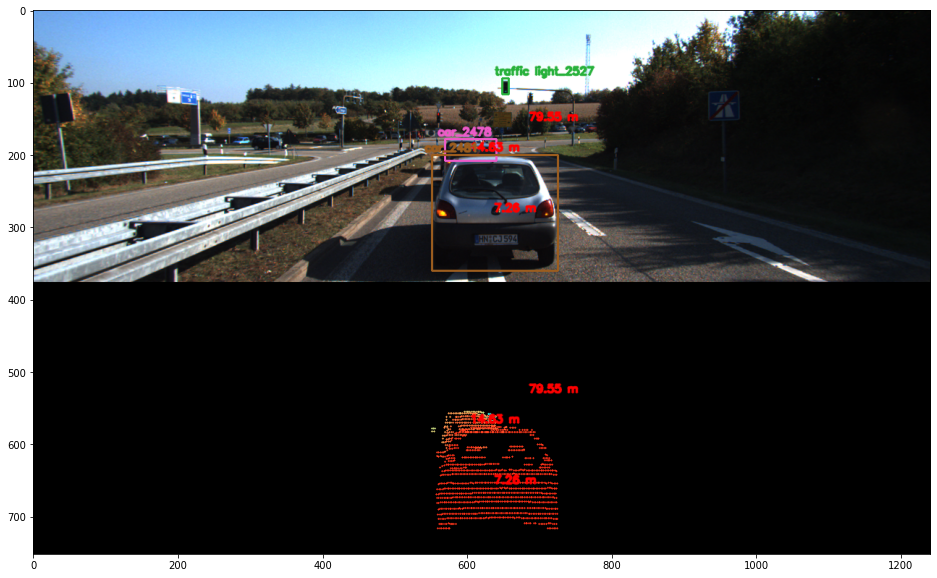

In [321]:
plt.imshow(stacked);

### Store results in a video


First get the proper frame rate. We will also need the time updates for the Kalman filter.



In [322]:
get_total_seconds = lambda hms: hms[0]*60*60 + hms[1]*60 + hms[2]


def timestamps2seconds(timestamp_path):
    ''' Reads in timestamp path and returns total seconds (does not account for day rollover '''
    timestamps = pd.read_csv(timestamp_path, 
                             header=None, 
                             squeeze=True).astype(object) \
                                          .apply(lambda x: x.split(' ')[1]) 
    
    # Get Hours, Minutes, and Seconds
    hours = timestamps.apply(lambda x: x.split(':')[0]).astype(np.float64)
    minutes = timestamps.apply(lambda x: x.split(':')[1]).astype(np.float64)
    seconds = timestamps.apply(lambda x: x.split(':')[2]).astype(np.float64)

    hms_vals = np.vstack((hours, minutes, seconds)).T
    
    total_seconds = np.array(list(map(get_total_seconds, hms_vals)))
    
    return total_seconds

In [323]:
cam2_total_seconds = timestamps2seconds(os.path.join(DATA_PATH, r'image_02/timestamps.txt'))

# camera 2 frames per second
cam2_fps = 1/np.median(np.diff(cam2_total_seconds))
cam2_fps

9.650971459539951

In [326]:
h, w, _ = stacked.shape
out = cv2.VideoWriter('track_vid_stacked_no_filter.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'), 
                      cam2_fps, 
                      (w,h))

for img in result_video:
    out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
out.release()